<a href="https://colab.research.google.com/github/paulc00/ML-Intro/blob/master/notebooks/extras/Scorecard_ODSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ScorecardODSC_7Aug
Created on Mon Aug  5 09:43:55 2019
@author: KAVITA DWIVEDI
"""

Edited: Paul Conway, Sep 2019

This shows the full machine learning pipeline for a realistic problem: financial credit scoring.

*See the acompanying slides for further explanation*

## Sec 1. Importing libraries

Here we import the necessary python packages

In [0]:
#Importing the Libraries

# Pandas for data manipulation
import pandas as pd
from pandas.core import algorithms

# Numpy for vectors, matrices and linear algebra
import numpy as np

# matplotlib and Seaborn for graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# scikit utilities for preprocessing, model selection and measuring performance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             accuracy_score, 
                             roc_curve, 
                             auc)

# ML models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# We'll use variane inflation factor to do some feature selection
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Some special dictionary types 
from collections import defaultdict, OrderedDict

from pathlib import Path  # for chekcing if we cloned the repository already

from scipy.stats import spearmanr
import re
import traceback
import string

from IPython.core.display import HTML

from pprint import pprint

In [0]:
# set random_state, to ensure results look the same every time
rs = 2

## Sec 2. Cloning The Github

In [0]:
if not Path("ScorecardODSC").is_dir():
  !git clone https://github.com/kavitablockyto/ScorecardODSC.git 

##Section 3. Importing the Dataset and Sampling

In [0]:
# defining path of Collection_Home3.xlsx
path=("/content/ScorecardODSC/Collection_Home3.xlsx")

#Reading the Dataset

df = pd.read_excel(path)

In [5]:
data_sample = df.sample(frac=0.2, random_state=rs)
data_sample.head()

,CODE_GENDER,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,OCCUPATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,DAYS_LAST_PHONE_CHANGE,TARGET
177958,F,Working,Higher education,Married,10512,2147,4746.0,438,1,1,0,Managers,0,1,Business Entity Type 3,105,0
128842,F,Pensioner,Secondary / secondary special,Widow,21497,365243,8186.0,4042,0,0,0,NaN,0,0,XNA,2300,0
146276,F,Commercial associate,Higher education,Single / not married,20031,6874,4092.0,3589,1,0,1,Managers,0,0,Other,545,0
259956,M,Commercial associate,Secondary / secondary special,Married,11835,5047,28.0,4235,1,0,0,Drivers,0,0,Business Entity Type 3,768,0
42348,F,Pensioner,Secondary / secondary special,Married,23096,365243,9705.0,4078,0,0,1,NaN,0,0,XNA,582,0


In [6]:
# Counting Target Variable numbers
df.TARGET.value_counts()

0    255011
1     23221
Name: TARGET, dtype: int64

In [7]:

data_sample.TARGET.value_counts()

0    50850
1     4796
Name: TARGET, dtype: int64

In [8]:
#Descriptive Stats
#Target Variable Count in data and sample

df.TARGET.value_counts()/len(df)
data_sample.TARGET.value_counts()/len(data_sample)

0    0.913812
1    0.086188
Name: TARGET, dtype: float64

In [9]:
# Data Description
data_sample.describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,DAYS_LAST_PHONE_CHANGE,TARGET
count,55646.000000,55646.000000,55646.000000,55646.000000,55646.000000,55646.000000,55646.000000,55646.000000,55646.000000,55646.000000,55646.000000
mean,16140.211893,69265.894781,5008.039482,3011.903803,0.815710,0.203033,0.282356,0.078119,0.230637,972.483934,0.086188
std,4336.041155,140683.409755,3518.077016,1497.841880,0.387724,0.402261,0.450150,0.268361,0.421244,830.864961,0.280644
min,7489.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12533.000000,956.000000,2065.000000,1770.250000,1.000000,0.000000,0.000000,0.000000,0.000000,274.000000,0.000000
50%,15869.000000,2266.000000,4520.500000,3271.000000,1.000000,0.000000,0.000000,0.000000,0.000000,779.000000,0.000000
75%,19726.000000,6001.750000,7507.750000,4308.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1581.000000,0.000000
max,25197.000000,365243.000000,24672.000000,6258.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4121.000000,1.000000


##Sec 4. Data Preparation 

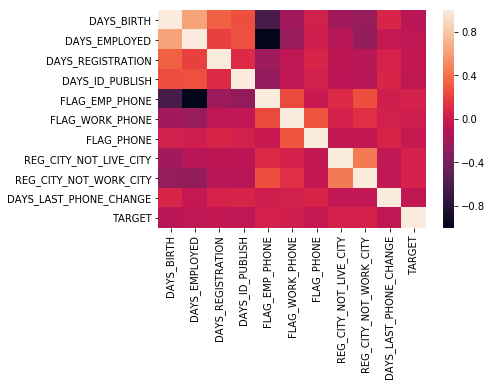

In [10]:
#Correlation Plot
corr = data_sample.corr()

# Plot a heatmap fo the correlations using Seaborn
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [11]:
# Missing Data

# Function to calculate missing values by column# Funct 
def missing_values_table(data_sample):
        # Total missing values
        mis_val = data_sample.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * data_sample.isnull().sum() / len(data_sample)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val , mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(data_sample.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# Missing values statistics
missing_values = missing_values_table(data_sample)
missing_values.head(20)

Your selected dataframe has 17 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
OCCUPATION_TYPE,17541,31.5


In [0]:
def transform_data(data):
  # Data transformation
  # Convert categorical values to numeric using label encoder
  # using defaultdict in this way allows us to fit_transform or inverse_transform
  # a categorical variable 
  d = defaultdict(LabelEncoder)

  # Encoding the categorical variable
  fit = data.select_dtypes(include=['object']).fillna('NA').apply(lambda x: d[x.name].fit_transform(x))

  # Convert the categorical columns based on encoding
  for i in list(d.keys()):
      data[i] = d[i].transform(data[i].fillna('NA'))
      
      features = data[data.columns.difference(['TARGET'])]
  return features.fillna(0), data['TARGET']

features, labels = transform_data(data_sample)

Weight of evidence (WOE) and Information value (IV) are widely used in credit scoring to measure the separation of good vs bad customers.
$$
\begin{align}
WOE & = \ln \left( \frac{positive\%}{negative\%} \right)\\
IV & = \sum (positive\% - negative\%) \times WOE
\end{align}
$$

The IV value can be used to select variables quickly:

| Information Value | Predictive Power |
|---|---|
| < 0.02 | Useless for prediction |
| 0.02 - 0.1 | Weak predictor |
| 0.1 - 0.3 | Medium predictor |
| 0.3 - 0.5 | Strong predictor |
| > 0.5 | Possibly too good to be true |

From: 
[https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb](https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb)

In [0]:
# Weight of evidence (WOE) and Information value (IV)
# Ref: https://github.com/Sundar0989/WOE-and-IV

# Maximum number of bins (categories) for numeric variable binning.
max_bin = 20
# Ensure binning produces at least 2 categories.
force_bin = 3


# define a monotonic numerical binning function for numeric values
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X', 'Y']][df1.X.isnull()]
    notmiss = df1[['X', 'Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, 
                               "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algorithms.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, 
                           "Bucket": pd.cut(notmiss.X, np.unique(bins), 
                                            include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({}, index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan}, index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4, ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT) * np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME', 'MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 
             'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT', 
             'DIST_NON_EVENT', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)


# De# define a monotocharacterical binning funclues
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X', 'Y']][df1.X.isnull()]
    notmiss = df1[['X', 'Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X', as_index=True)
    
    d3 = pd.DataFrame({}, index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan}, index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4, ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME', 'MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT', 'DIST_NON_EVENT', 'WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)


def data_vars(df1, target):
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv, ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)
    
final_iv, IV = data_vars(data_sample[data_sample.columns.difference(['TARGET'])], data_sample.TARGET)
IV = IV.rename(columns={'VAR_NAME':'index'})
IV.sort_values(['IV'], ascending=0)

hi_ivs = list(IV.loc[IV['IV'] >= 0.02].sort_values(['IV'],ascending=0)['index'])

##Sec 5.  Modeling using Support Vector Machine 

In [14]:
# Split our data into training and test sets with the reduced feature set
train_features, test_features, train_labels, test_labels = train_test_split(features[hi_ivs], labels, test_size = 0.4, random_state=rs)

#Support Vector Machine Classsifier
clf = SVC(gamma='scale', random_state=rs)
clf.fit(train_features, train_labels)

train_pred = clf.predict(train_features)
test_pred = clf.predict(test_features)

clf.score(test_features, test_labels)

0.9142369378678288

That accuracy looks really impressive ... until you look at how many times each label value was predicted by the model.

In [15]:
print(f"True label counts:\n{test_labels.value_counts()}\n\nPredicted label counts:\n{pd.Series(test_pred).value_counts()}")

True label counts:
0    20350
1     1909
Name: TARGET, dtype: int64

Predicted label counts:
0    22259
dtype: int64


All the values predicted by our model are zero. Prediction accuracy can't give us a good sense of how well the model has worked because almost all of the data we used for training was negative. We need to dig deeper into our results by looking at some metrics related to how well each of the labels are picked relative to their true labels.

A **confusion matrix** shows counts of true negatives, true positives, false negatives and false positives.

![confusion template](http://drive.google.com/uc?export=view&id=11MS9Xw6kQA7jda9hwc2P3Upr7AfvXvV9)


In [0]:
def print_confusion_matrix(act_labels, pred_labels):
  cm = confusion_matrix(act_labels, pred_labels)
  sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 18}, cmap=sns.color_palette("Blues", 100), cbar=None)
  plt.ylabel('True', fontsize=24)
  plt.xlabel('Predicted', fontsize=24)
  plt.tick_params(axis="x", labelsize=18)
  plt.tick_params(axis="y", labelsize=18)
  plt.plot()

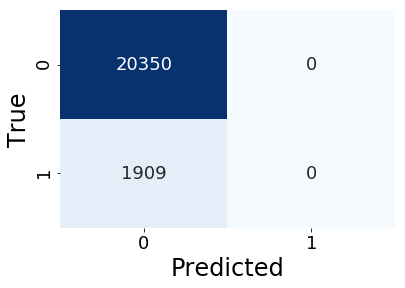

In [17]:
print_confusion_matrix(test_labels, test_pred)


The *classification report* in scikit learn gives us:

**Precision** talks about how precise/accurate your model is out of those predicted positive. It represents the proportion of *positive results* that are correctly labeled as positive.

$$Precision = \frac{True\ Positives}{True\ Positives + False\ Positives}$$

**Recall** measures the proportion of *actual positives* that are correctly identified as such (e.g., the percentage of sick people who are correctly identified as having the condition).

$$Recall = \frac{True\ Positives}{True\ Positives + False\ Negatives}$$

**F1 Score** is a measure of accuracy using precision and recall. It takes the occurence of both false positives and false negatives into account.

$$F_1\ Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

In [18]:
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96     20350
           1       0.00      0.00      0.00      1909

    accuracy                           0.91     22259
   macro avg       0.46      0.50      0.48     22259
weighted avg       0.84      0.91      0.87     22259



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


##Sec 6. Modeling using RandomForest

The ramdom forest classifier can identify which features are more important for accurate classification. This can be used for feature selection.

In [19]:
# Variable Importance
clf = RandomForestClassifier(random_state=rs)

clf.fit(features, labels)

preds = clf.predict(features)

VI = pd.DataFrame(clf.feature_importances_, columns = ["RF"], index=features.columns)

VI = VI.reset_index()

print(f" Feature importance from random forest:\n{VI.sort_values(['RF'], ascending=0)}")

hi_vis = list(VI.loc[VI['RF'] >= 0.02].sort_values(['RF'],ascending=0)['index'])

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


 Feature importance from random forest:
                     index        RF
1               DAYS_BIRTH  0.162431
3          DAYS_ID_PUBLISH  0.155856
5        DAYS_REGISTRATION  0.154515
4   DAYS_LAST_PHONE_CHANGE  0.135749
2            DAYS_EMPLOYED  0.132665
13       ORGANIZATION_TYPE  0.068926
12         OCCUPATION_TYPE  0.057146
10      NAME_FAMILY_STATUS  0.034265
7               FLAG_PHONE  0.016602
9      NAME_EDUCATION_TYPE  0.015661
0              CODE_GENDER  0.014713
8          FLAG_WORK_PHONE  0.014694
11        NAME_INCOME_TYPE  0.014288
15  REG_CITY_NOT_WORK_CITY  0.012741
14  REG_CITY_NOT_LIVE_CITY  0.008769
6           FLAG_EMP_PHONE  0.000980


In [0]:
# Split our data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features[hi_vis], labels, test_size = 0.2, random_state=rs)

# Refit the model with the reduced feature set
clf.fit(train_features, train_labels)

train_pred = clf.predict(train_features)
test_pred = clf.predict(test_features)

accuracy_train = accuracy_score(train_pred, train_labels)
accuracy_test = accuracy_score(test_pred, test_labels)

Once again we'll see that accuracy does not necessarily reflect how well the model is performing.

We'll look at the **area under the curve (AUC)** for the **receiver operating characteristic (ROC)** curve to get a better idea of true model performance.

In [0]:
def plot_roc_curve(fpr, tpr):
    # plt.rcParams["figure.figsize"] = (10, 8)
    plt.figure(figsize=(10,8))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [0]:
fpr_train, tpr_train, _ = roc_curve(np.array(train_labels), clf.predict_proba(train_features)[:,1])
auc_train = auc(fpr_train, tpr_train)
fpr_test, tpr_test, _ = roc_curve(np.array(test_labels), clf.predict_proba(test_features)[:,1])
auc_test = auc(fpr_test, tpr_test)

In [23]:
print(f"Training accuracy = {accuracy_train}\nTest accuracy = {accuracy_test}")
print(f"Training AUC = {auc_train}\nTest AUC = {auc_test}")

Training accuracy = 0.9820289334171983
Test accuracy = 0.9115902964959569
Training AUC = 0.9996643803568557
Test AUC = 0.5498794965471476


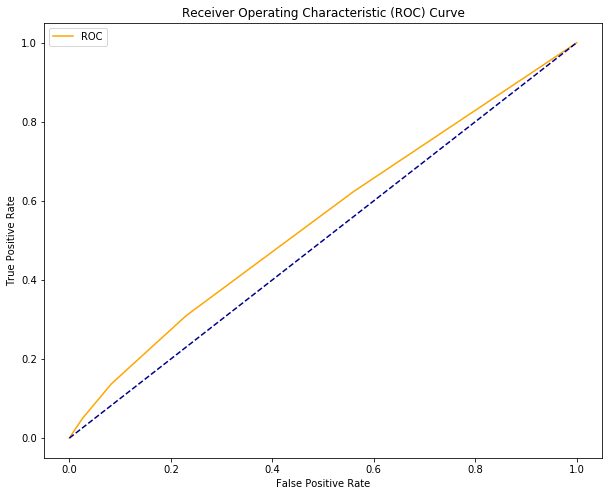

In [24]:
plot_roc_curve(fpr_test, tpr_test)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10158
           1       0.12      0.00      0.00       972

    accuracy                           0.91     11130
   macro avg       0.52      0.50      0.48     11130
weighted avg       0.84      0.91      0.87     11130



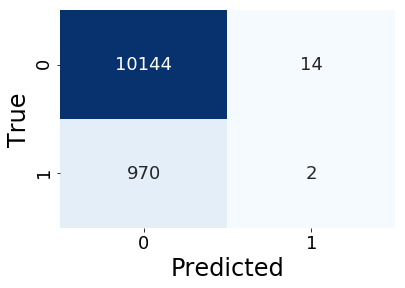

In [25]:
print_confusion_matrix(test_labels, test_pred)
print(classification_report(test_labels, test_pred))

##Sec 7. Modeling Using Gradient Boosting

**Multicollinearity** refers to predictors that are correlated with other predictors.  Multicollinearity occurs when your model includes multiple factors that are correlated not just to your response variable, but also to each other. In other words, it results when you have factors that are a bit redundant.

One way to measure multicollinearity is the **variance inflation factor (VIF)**, which assesses how much the variance of an estimated regression coefficient increases if your predictors are correlated.  If no factors are correlated, the VIFs will all be 1.

In [26]:
# Multicollinearity
def calculate_vif(features):
    vif = pd.DataFrame()
    vif["Features"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]    
    return(vif)

# Model   
vif = calculate_vif(features)
print(vif.sort_values('VIF'))

print("\nFeatures with low multicollinearity:")
low_mc = list(vif.loc[vif['VIF'] <= 10].sort_values(['VIF'], ascending=0)['Features'])
pprint(low_mc)

# Split our data into training and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features[low_mc], labels, test_size = 0.4, random_state=rs)
train_labels = train_labels.reset_index(drop=True)
test_labels = test_labels.reset_index(drop=True)

                  Features        VIF
14  REG_CITY_NOT_LIVE_CITY   1.377137
8          FLAG_WORK_PHONE   1.495648
7               FLAG_PHONE   1.565310
0              CODE_GENDER   1.614113
15  REG_CITY_NOT_WORK_CITY   1.761182
4   DAYS_LAST_PHONE_CHANGE   2.443368
10      NAME_FAMILY_STATUS   2.996922
11        NAME_INCOME_TYPE   3.347807
5        DAYS_REGISTRATION   3.439765
13       ORGANIZATION_TYPE   5.251824
3          DAYS_ID_PUBLISH   5.584025
12         OCCUPATION_TYPE   6.307613
9      NAME_EDUCATION_TYPE   7.724784
2            DAYS_EMPLOYED  15.217120
1               DAYS_BIRTH  28.341692
6           FLAG_EMP_PHONE  32.906376

Features with low multicollinearity:
['NAME_EDUCATION_TYPE',
 'OCCUPATION_TYPE',
 'DAYS_ID_PUBLISH',
 'ORGANIZATION_TYPE',
 'DAYS_REGISTRATION',
 'NAME_INCOME_TYPE',
 'NAME_FAMILY_STATUS',
 'DAYS_LAST_PHONE_CHANGE',
 'REG_CITY_NOT_WORK_CITY',
 'CODE_GENDER',
 'FLAG_PHONE',
 'FLAG_WORK_PHONE',
 'REG_CITY_NOT_LIVE_CITY']


In [0]:
#GradientBoosting
# clf = GradientBoostingClassifier(learning_rate=.03, random_state=rs)
clf = GradientBoostingClassifier(learning_rate=.09, random_state=rs)
# clf = GradientBoostingClassifier(random_state=rs)

clf.fit(train_features, train_labels)

train_pred = clf.predict(train_features)
test_pred = clf.predict(test_features)

In [0]:
accuracy_train = accuracy_score(train_pred, train_labels)
accuracy_test = accuracy_score(test_pred, test_labels)

fpr_train, tpr_train, _ = roc_curve(np.array(train_labels), clf.predict_proba(train_features)[:, 1])
auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(np.array(test_labels), clf.predict_proba(test_features)[:, 1])
auc_test = auc(fpr_test, tpr_test)

In [29]:
print(f"Training accuracy = {accuracy_train}\nTest accuracy = {accuracy_test}")
print(f"Training AUC = {auc_train}\nTest AUC = {auc_test}")

Training accuracy = 0.9136490250696379
Test accuracy = 0.9141920122197763
Training AUC = 0.6878262249655038
Test AUC = 0.642715817870349


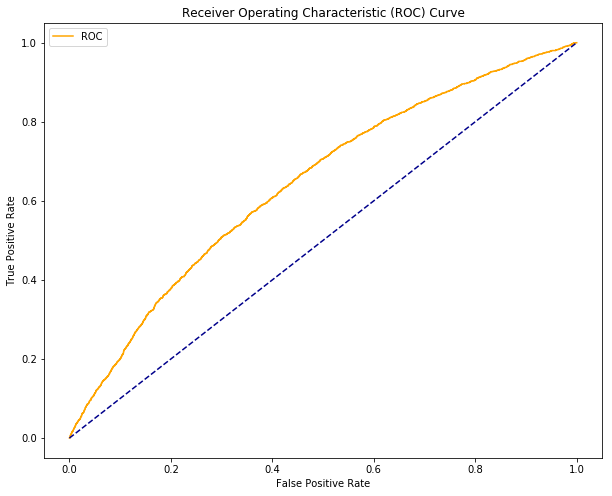

In [30]:
plot_roc_curve(fpr_test, tpr_test)

              precision    recall  f1-score   support

           0       0.91      1.00      0.96     20350
           1       0.00      0.00      0.00      1909

    accuracy                           0.91     22259
   macro avg       0.46      0.50      0.48     22259
weighted avg       0.84      0.91      0.87     22259



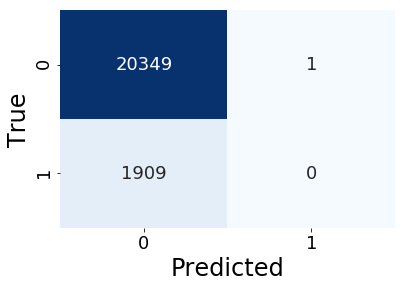

In [31]:
print_confusion_matrix(test_labels, test_pred)
print(classification_report(test_labels, test_pred))

## Sec 8. Validation and Performance Measurement of Model

In [0]:
# Deciles and Kolmogarov Smirnoff Statistics

def plot_pandas_style(styler):
    html = '\n'.join([line.lstrip() for line in styler.render().split('\n')])
    return HTML(html)

def highlight_max(s, color='yellow'):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: {}'.format(color) if v else '' for v in is_max]

def decile_labels(agg1, label, color='skyblue'):
    agg_dummy = pd.DataFrame(OrderedDict((('TOTAL', 0), ('TARGET', 0), ('NONTARGET', 0), ('PCT_TGT', 0), ('CUM_TGT', 0), ('CUM_NONTGT', 0), ('DIST_TGT', 0), ('DIST_NONTGT', 0), ('SPREAD', 0))), index=[0])
    agg1 = agg1.append(agg_dummy).sort_index()
    agg1.index.name = label
    agg1 = agg1.style.apply(highlight_max, color = 'yellow', subset=['SPREAD'])
    agg1.bar(subset=['TARGET'], color='{}'.format(color))
    agg1.bar(subset=['TOTAL'], color='{}'.format(color))
    agg1.bar(subset=['PCT_TGT'], color='{}'.format(color))
    return(agg1)
    
def deciling(data, decile_by, target, nontarget):
    inputs = list(decile_by)
    inputs.extend((target, nontarget))
    decile = data[inputs]
    grouped = decile.groupby(decile_by)
    agg1 = pd.DataFrame({}, index=[])
    agg1['TOTAL'] = grouped.sum()[nontarget] + grouped.sum()[target]
    agg1['TARGET'] = grouped.sum()[target]
    agg1['NONTARGET'] = grouped.sum()[nontarget]
    agg1['PCT_TGT'] = grouped.mean()[target] * 100
    agg1['CUM_TGT'] = grouped.sum()[target].cumsum()
    agg1['CUM_NONTGT'] = grouped.sum()[nontarget].cumsum()
    agg1['DIST_TGT'] = agg1['CUM_TGT']/agg1['TARGET'].sum() * 100
    agg1['DIST_NONTGT'] = agg1['CUM_NONTGT']/agg1['NONTARGET'].sum() * 100
    agg1['SPREAD'] = (agg1['DIST_TGT'] - agg1['DIST_NONTGT'])
    agg1 = decile_labels(agg1, 'DECILE', color='skyblue')
    return(plot_pandas_style(agg1))
    
def scoring (features, clf, target): 
  score=pd.DataFrame(clf.predict_proba(features)[:, 1], columns = ['SCORE'])
  score['DECILE'] = pd.qcut(score['SCORE'].rank(method = 'first'), 10, labels=range(10, 0, -1))
  score['DECILE'] = score['DECILE'].astype(float)
  score['TARGET'] = target
  score['NONTARGET'] = 1 - target
  return score

In [0]:
scores_train = scoring(train_features, clf, train_labels)
scores_test = scoring(test_features, clf, test_labels)

In [34]:
deciling(scores_train, ['DECILE'], 'TARGET', 'NONTARGET')

,TOTAL,TARGET,NONTARGET,PCT_TGT,CUM_TGT,CUM_NONTGT,DIST_TGT,DIST_NONTGT,SPREAD
DECILE,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0
1.0,3339,713,2626,21.3537,713,2626,24.6969,8.60984,16.0871
2.0,3339,476,2863,14.2558,1189,5489,41.1846,17.9967,23.1879
3.0,3338,371,2967,11.1144,1560,8456,54.0353,27.7246,26.3107
4.0,3339,319,3020,9.55376,1879,11476,65.0849,37.6262,27.4586
5.0,3338,242,3096,7.24985,2121,14572,73.4673,47.777,25.6902
6.0,3339,221,3118,6.61875,2342,17690,81.1223,58,23.1223
7.0,3339,192,3147,5.75022,2534,20837,87.7728,68.318,19.4547
8.0,3338,155,3183,4.6435,2689,24020,93.1417,78.7541,14.3876


In [35]:
deciling(scores_test, ['DECILE'], 'TARGET', 'NONTARGET')

,TOTAL,TARGET,NONTARGET,PCT_TGT,CUM_TGT,CUM_NONTGT,DIST_TGT,DIST_NONTGT,SPREAD
DECILE,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0
1.0,2226,356,1870,15.9928,356,1870,18.6485,9.18919,9.45932
2.0,2226,331,1895,14.8697,687,3765,35.9874,18.5012,17.4862
3.0,2226,241,1985,10.8266,928,5750,48.6118,28.2555,20.3563
4.0,2226,201,2025,9.02965,1129,7775,59.1409,38.2064,20.9345
5.0,2225,188,2037,8.44944,1317,9812,68.989,48.2162,20.7728
6.0,2226,162,2064,7.27763,1479,11876,77.4751,58.3587,19.1164
7.0,2226,135,2091,6.06469,1614,13967,84.5469,68.6339,15.913
8.0,2226,106,2120,4.7619,1720,16087,90.0995,79.0516,11.0479


In [0]:
 #Gains Chart2
    
def plots(agg1, target, type):
  plt.figure(1, figsize=(20, 5))
  plt.subplot(131)
  plt.plot(agg1['DECILE'], agg1['ACTUAL'], label='Actual')
  plt.plot(agg1['DECILE'], agg1['PRED'], label='Pred')
  plt.xticks(range(10, 110, 10))
  plt.legend(fontsize=15)
  plt.grid(True)
  plt.title('Actual vs Predicted', fontsize=20)
  plt.xlabel("Population %", fontsize=15)
  plt.ylabel(str(target) + " " + str(type) + " %", fontsize=15)

  plt.subplot(132)
  X = agg1['DECILE'].tolist()
  X.append(0)
  Y = agg1['DIST_TGT'].tolist()
  Y.append(0)
  plt.plot(sorted(X), sorted(Y))
  plt.plot([0, 100], [0, 100], 'r--')
  plt.xticks(range(0, 110, 10))
  plt.yticks(range(0, 110, 10))
  plt.grid(True)
  plt.title('Cumulative Gains Chart', fontsize=20)
  plt.xlabel("Population %", fontsize=15)
  plt.ylabel(str(target) + str(" DISTRIBUTION") + " %", fontsize=15)
  plt.annotate(round(agg1[agg1['DECILE'] == 30].DIST_TGT.item(), 2), xy=[30, 30], 
          xytext=(25, agg1[agg1['DECILE'] == 30].DIST_TGT.item() + 5), fontsize = 13)
  plt.annotate(round(agg1[agg1['DECILE'] == 50].DIST_TGT.item(), 2), xy=[50, 50], 
          xytext=(45, agg1[agg1['DECILE'] == 50].DIST_TGT.item() + 5), fontsize = 13)

  plt.subplot(133)
  plt.plot(agg1['DECILE'], agg1['LIFT'])
  plt.axhline(y=1, C='r', ls='--')
  plt.xticks(range(10, 110, 10))
  plt.grid(True)
  plt.title('Lift Chart', fontsize=20)
  plt.xlabel("Population %", fontsize=15)
  plt.ylabel("Lift", fontsize=15)

  plt.tight_layout()

def gains(data, decile_by, target, score):
  inputs = list(decile_by)
  inputs.extend((target, score))
  decile = data[inputs]
  grouped = decile.groupby(decile_by)
  agg1 = pd.DataFrame({}, index=[])
  agg1['ACTUAL'] = grouped.mean()[target]*100
  agg1['PRED'] = grouped.mean()[score]*100
  agg1['DIST_TGT'] = grouped.sum()[target].cumsum()/grouped.sum()[target].sum()*100
  agg1.index.name = 'DECILE'
  agg1 = agg1.reset_index()
  agg1['DECILE'] = agg1['DECILE']*10
  agg1['LIFT'] = agg1['DIST_TGT']/agg1['DECILE']
  plots(agg1, target, 'Distribution')


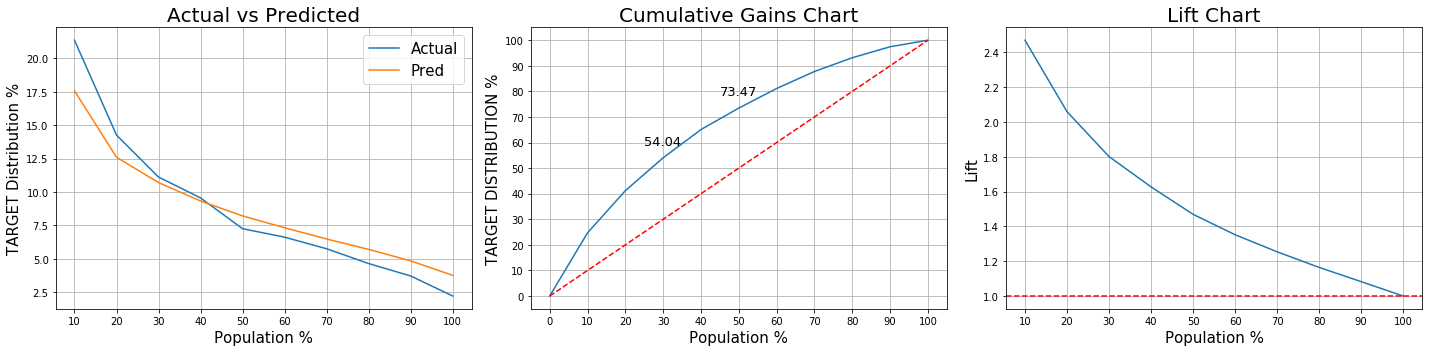

In [37]:
lift_train = pd.concat([train_features, scores_train], axis=1)
lift_test = pd.concat([test_features, scores_test], axis=1)

gains(lift_train, ['DECILE'], 'TARGET', 'SCORE')

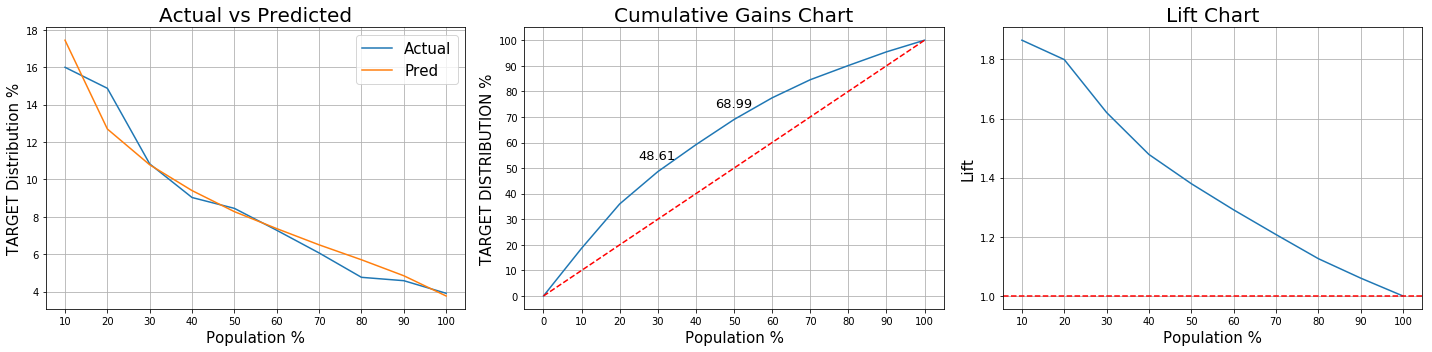

In [38]:
gains(lift_test, ['DECILE'], 'TARGET', 'SCORE')